In [ ]:
#Loading librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.corpus import stopwords
from textblob import TextBlob
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten
from tensorflow.keras.layers import  LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from collections import Counter
import random

# Dataset exploration

In [ ]:
#csv file path
path = "C:\\Users\\Aziz\\Desktop\\Spam Detection\\archive\\spam.csv"
encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1', 'utf-16']

for encoding in encodings_to_try:
    try:
        x = pd.read_csv(path, encoding=encoding)
        print("File read successfully with encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("UnicodeDecodeError with encoding:", encoding)
        pass

UnicodeDecodeError with encoding: utf-8
File read successfully with encoding: latin-1


In [ ]:
#"Visualising the dataset
x

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


Spam generally refers to unsolicited or unwanted messages, often sent in bulk, typically via email, text messages, social media, or other online platforms. These messages are usually intended for advertising, spreading malware, phishing, or other malicious purposes

In [ ]:
#Dropping extra columns
c = ['v1', 'v2']
x = x[c]
pd.set_option('display.max_colwidth', None)
x

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


In [ ]:
#Renaming columns to more relevent names
x.rename(columns = {'v1':'labels', 'v2':'message'}, inplace=True)
x.head()

C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\2356009799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns = {'v1':'labels', 'v2':'message'}, inplace=True)


,labels,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [ ]:
#Checking the dataset stats
x.info()
x.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   labels   5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,labels,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
#Eliminating duplicate messages
x.drop_duplicates(inplace=True)
x.shape

C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\3072126943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop_duplicates(inplace=True)


(5169, 2)

In [ ]:
#Checking for missing values
mi = x.isnull().sum()

# Display the count of missing values in each column
print("Missing values in each column:")
print(mi)

Missing values in each column:
labels     0
message    0
dtype: int64


In [ ]:
#Label encoding the target column
encoder = LabelEncoder()
x['labels'] = encoder.fit_transform(x['labels'])
# 0 -> ham   1->spam
x.head()

C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\3564369234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['labels'] = encoder.fit_transform(x['labels'])


,labels,message
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


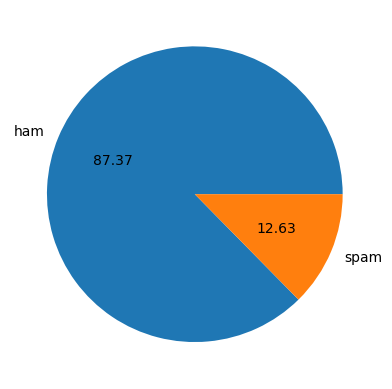

In [ ]:
#Visualising data balance
plt.pie(x['labels'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()
#=> Unbalanced data

In [ ]:
#counting charcacters , words and sentences
x['char_count'] = x['message'].apply(len)
x['words_count'] = x['message'].apply(lambda z:len(nltk.word_tokenize(z)))
x['sentence_count'] = x['message'].apply(lambda z:len(nltk.sent_tokenize(z)))

C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\370142664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['char_count'] = x['message'].apply(len)
C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\370142664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['words_count'] = x['message'].apply(lambda z:len(nltk.word_tokenize(z)))
C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\370142664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [ ]:
#Counting capital letters frequency , symbols and numbers usage
def calculate_other_metrics(text):
    # Calculate capital letters frequency
    capital_letters = sum(1 for char in text if char.isupper())
    total_letters = sum(1 for char in text if char.isalpha())
    if total_letters > 0:
        capital_letters_frequency = capital_letters / total_letters
    else:
        capital_letters_frequency = 0

    # Calculate unique symbols usage
    unique_symbols = sum(1 for char in text if char in string.punctuation)
    total_symbols = len(set([char for char in text if char in string.punctuation]))
    if total_symbols > 0:
        unique_symbols_usage = unique_symbols / total_symbols
    else:
        unique_symbols_usage = 0

    # Calculate numbers usage frequency
    numbers = sum(1 for char in text if char.isdigit())
    total_chars = sum(1 for char in text if char.isalnum())
    if total_chars > 0:
        numbers_usage_frequency = numbers / total_chars
    else:
        numbers_usage_frequency = 0

    return capital_letters_frequency, unique_symbols_usage, numbers_usage_frequency


In [ ]:
#apply functions above to add extra features to the  dataframe
x['Capital_Letters_Frequency'], x['Unique_Symbols_Usage'], x['Numbers_Usage_Frequency'] = zip(*x['message'].apply(calculate_other_metrics))
x.head()

C:\Users\Aziz\AppData\Local\Temp\ipykernel_13632\2016763898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Capital_Letters_Frequency'], x['Unique_Symbols_Usage'], x['Numbers_Usage_Frequency'] = zip(*x['message'].apply(calculate_other_metrics))
C:\Users\Aziz\AppData\Local\Temp\ipykernel_13632\2016763898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Capital_Letters_Frequency'], x['Unique_Symbols_Usage'], x['Numbers_Usage_Frequency'] = zip(*x['message'].apply(calculate_other_metrics))
C:\Users

,labels,message,char_count,words_count,sentence_count,Capital_Letters_Frequency,Unique_Symbols_Usage,Numbers_Usage_Frequency
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,24,2,0.036145,4.5,0.000000
1,0,Ok lar... Joking wif u oni...,29,8,2,0.111111,6.0,0.000000
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,37,2,0.103093,1.2,0.204918
3,0,U dun say so early hor... U c already then say...,49,13,1,0.060606,6.0,0.000000
4,0,"Nah I don't think he goes to usf, he lives around here though",61,15,1,0.042553,1.0,0.000000


C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

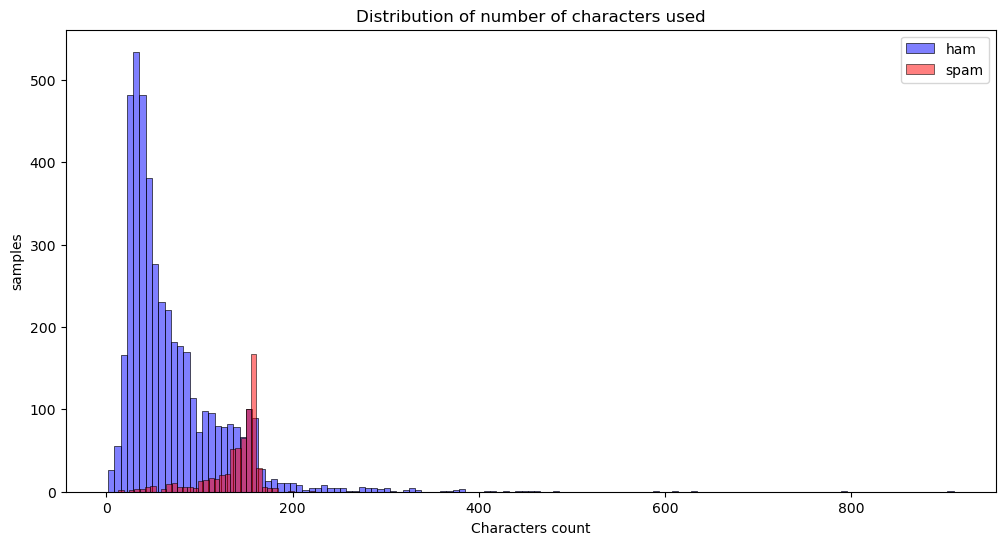

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(x[x['labels'] == 0]['char_count'], color='blue', alpha=0.5, label='ham')
sns.histplot(x[x['labels'] == 1]['char_count'], color='red', alpha=0.5, label='spam')

plt.xlabel('Characters count')
plt.ylabel('samples')
plt.title('Distribution of number of characters used')
plt.legend()
plt.show()

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

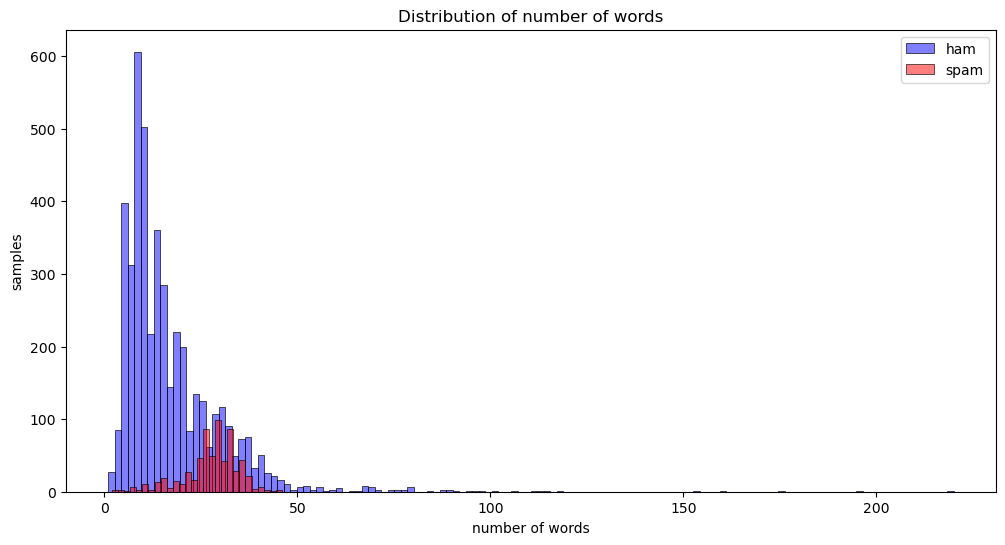

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(x[x['labels'] == 0]['words_count'], color='blue', alpha=0.5, label='ham')
sns.histplot(x[x['labels'] == 1]['words_count'], color='red', alpha=0.5, label='spam')

plt.xlabel('number of words')
plt.ylabel('samples')
plt.title('Distribution of number of words')
plt.legend()
plt.show()

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

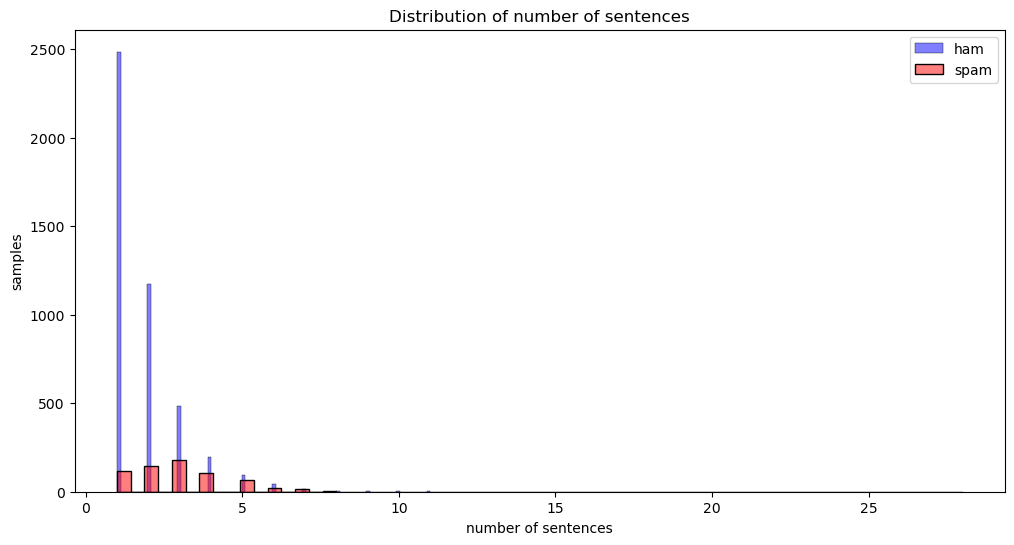

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(x[x['labels'] == 0]['sentence_count'], color='blue', alpha=0.5, label='ham')
sns.histplot(x[x['labels'] == 1]['sentence_count'], color='red', alpha=0.5, label='spam')

plt.xlabel('number of sentences')
plt.ylabel('samples')
plt.title('Distribution of number of sentences')
plt.legend()
plt.show()

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

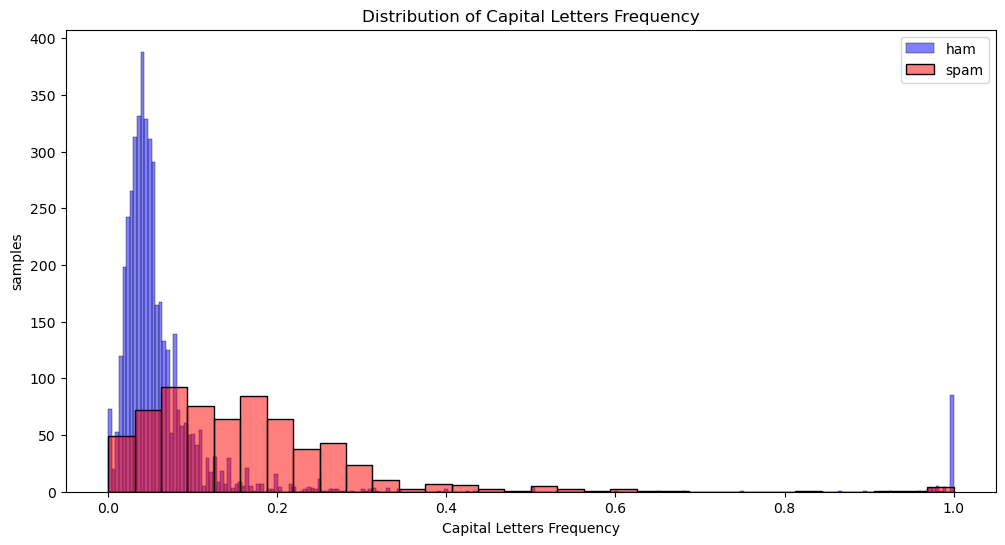

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(x[x['labels'] == 0]['Capital_Letters_Frequency'], color='blue', alpha=0.5, label='ham')
sns.histplot(x[x['labels'] == 1]['Capital_Letters_Frequency'], color='red', alpha=0.5, label='spam')

plt.xlabel('Capital Letters Frequency')
plt.ylabel('samples')
plt.title('Distribution of Capital Letters Frequency')
plt.legend()
plt.show()

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

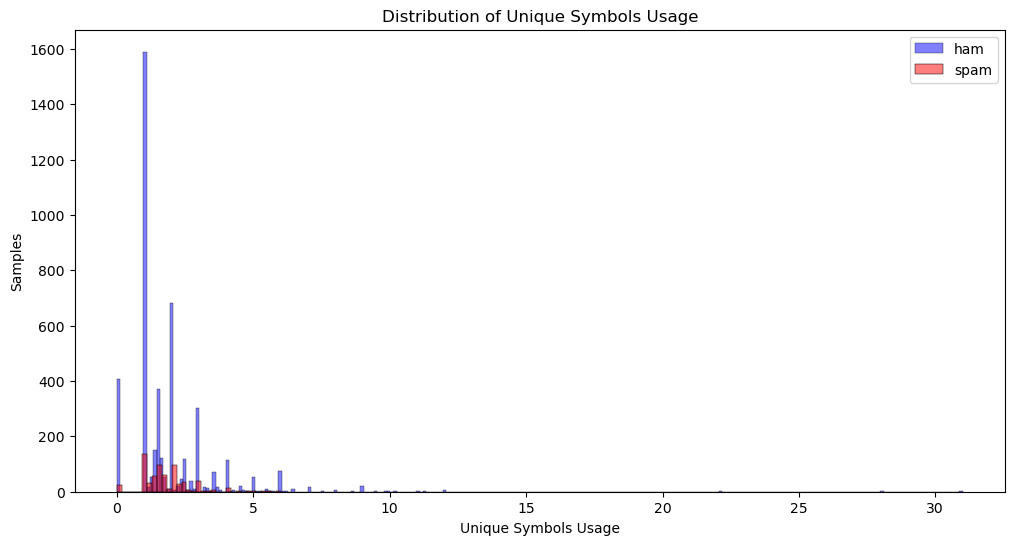

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(x[x['labels'] == 0]['Unique_Symbols_Usage'], color='blue', alpha=0.5, label='ham')
sns.histplot(x[x['labels'] == 1]['Unique_Symbols_Usage'], color='red', alpha=0.5, label='spam')

plt.xlabel('Unique Symbols Usage')
plt.ylabel('Samples')
plt.title('Distribution of Unique Symbols Usage')
plt.legend()
plt.show()

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

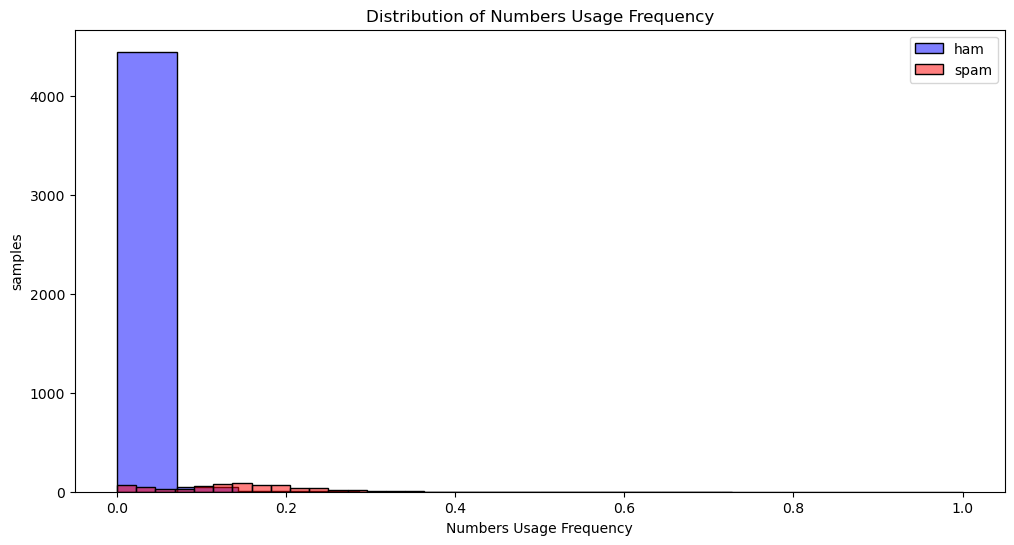

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(x[x['labels'] == 0]['Numbers_Usage_Frequency'], color='blue', alpha=0.5, label='ham')
sns.histplot(x[x['labels'] == 1]['Numbers_Usage_Frequency'], color='red', alpha=0.5, label='spam')

plt.xlabel('Numbers Usage Frequency')
plt.ylabel('samples')
plt.title('Distribution of Numbers Usage Frequency')
plt.legend()
plt.show()

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

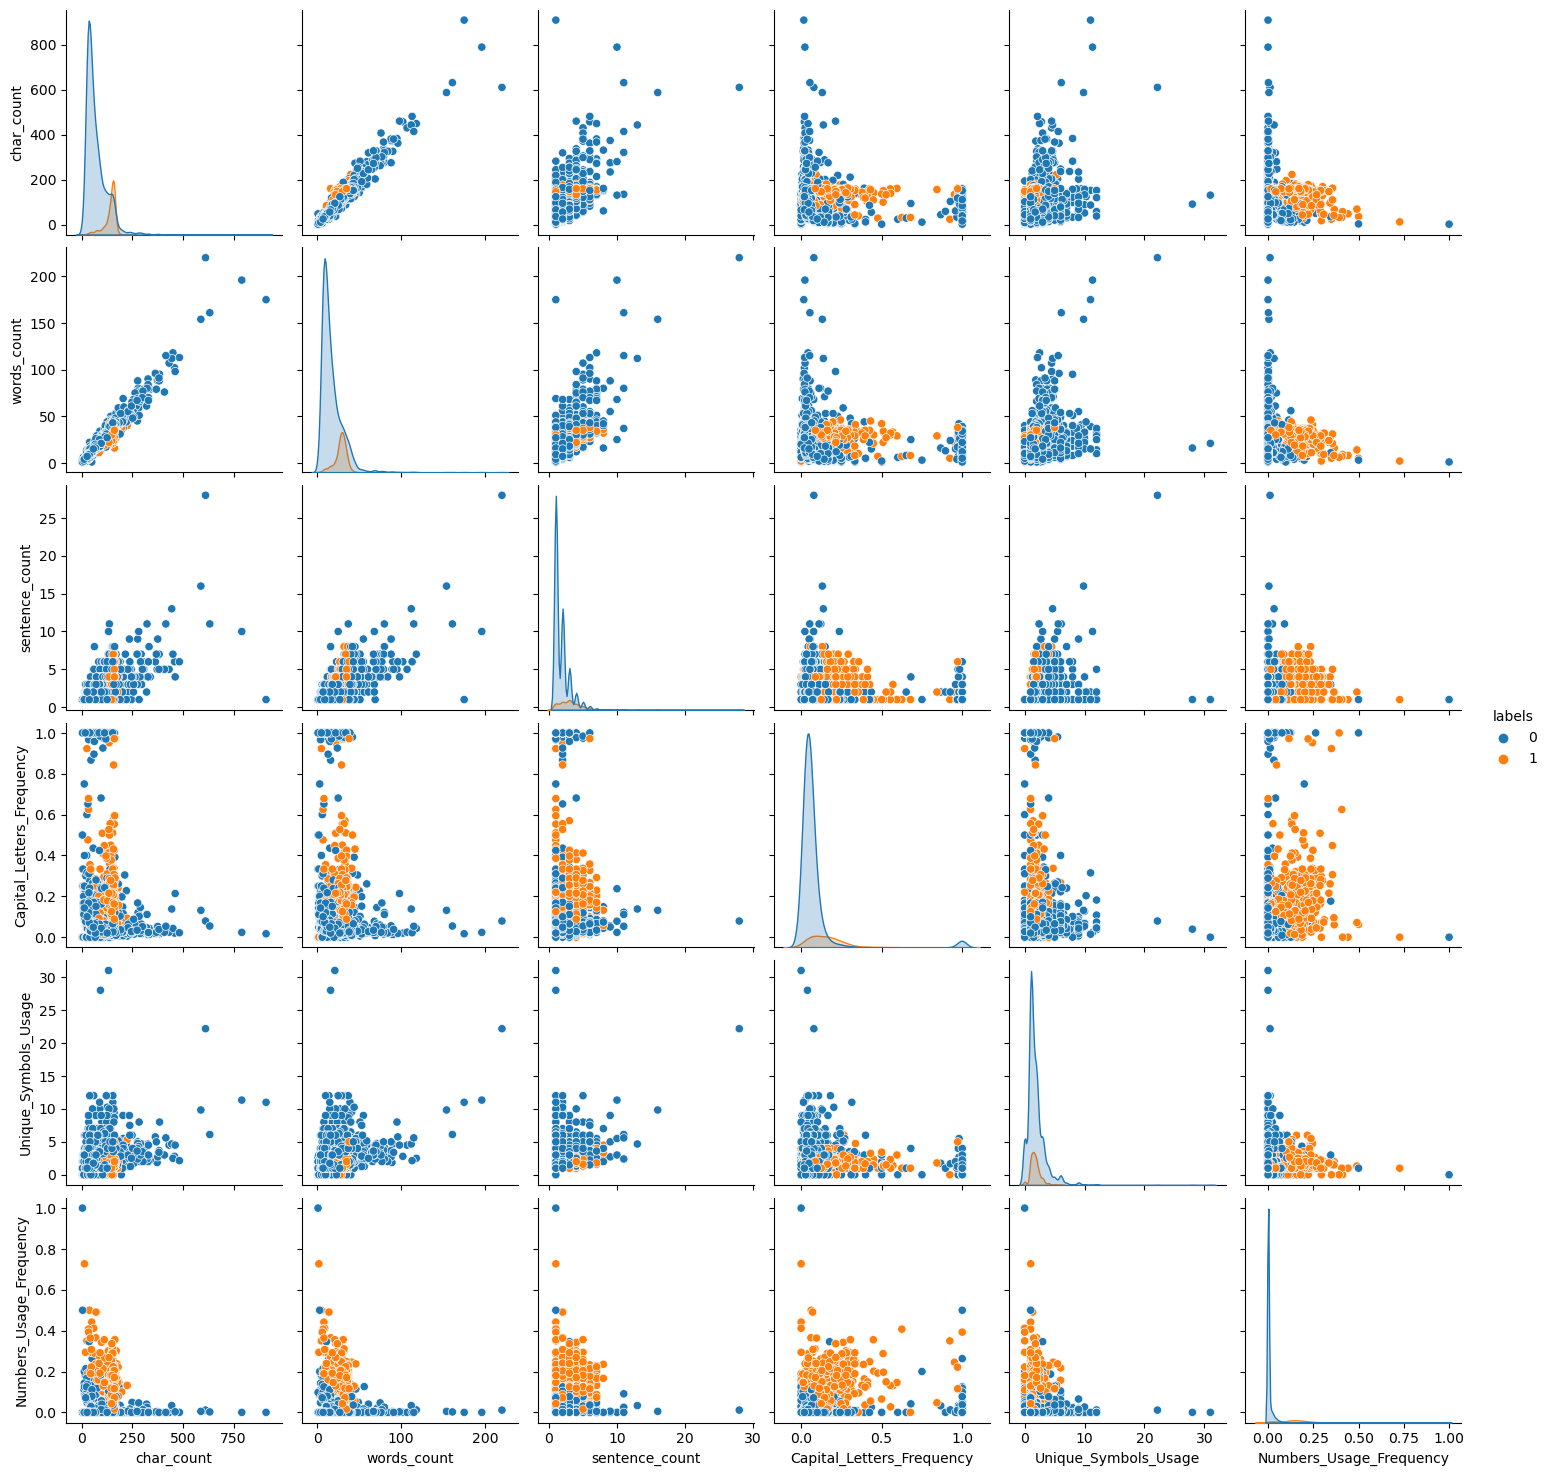

In [ ]:
sns.pairplot(x,hue='labels')

<Axes: >

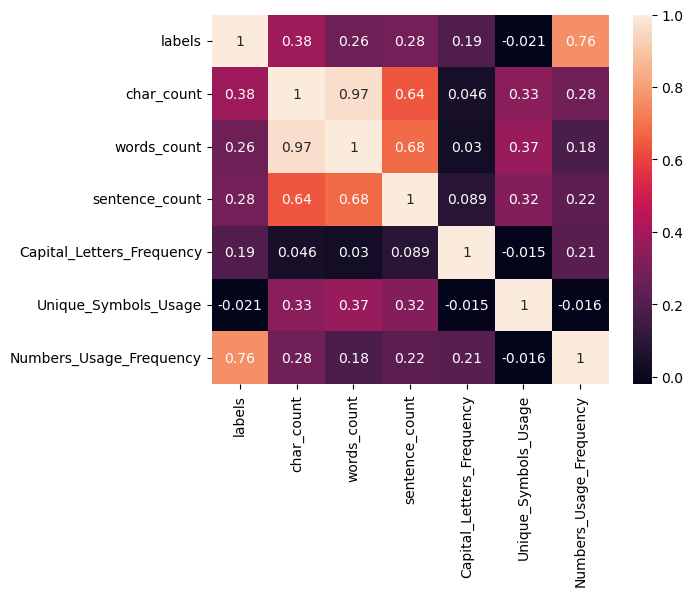

In [ ]:
x1=x.drop(columns='message')
sns.heatmap(x1.corr(),annot=True)

# Data preprocessing

In [ ]:
# Convert text to lowercase
def low_text(text):
    text_lower = text.lower()
    return text_lower

In [ ]:
def corr_text(text):
    # Correct grammar mistakes
    text = str(TextBlob(text).correct())
    return text

In [ ]:
# Tokenization removing special characters and lematizing
def tokenise_filter(text):
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens if token.isalnum()]
    # Remove stop words and punctuations
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    #Lematizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return  lemmatized_tokens

In [ ]:
#application of the preprocessing pipeline over the dataframe
x['message'] = x['message'].apply(low_text)
x['message'] = x['message'].apply(corr_text)
x['message'] = x['message'].apply(tokenise_filter)
x['Capital_Letters_Frequency'], x['Unique_Symbols_Usage'], x['Numbers_Usage_Frequency'] = zip(*x['message'].apply(calculate_other_metrics))
x.head()

C:\Users\Aziz\AppData\Local\Temp\ipykernel_15324\3920109038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Capital_Letters_Frequency'], x['Unique_Symbols_Usage'], x['Numbers_Usage_Frequency'] = zip(*x['message'].apply(calculate_other_metrics))


,labels,message,char_count,words_count,sentence_count,Capital_Letters_Frequency,Unique_Symbols_Usage,Numbers_Usage_Frequency
0,0,"[go, point, crazy, available, boris, n, great, world, la, e, buffet, line, got, wat]",111,24,2,0.0,0,0.000000
1,0,"[ok, war, joking, u]",29,8,2,0.0,0,0.000000
2,1,"[free, entry, 2, wily, come, win, cup, final, must, may, text, 87121, receive, entry, question, st, txt, rate, c, apply, 08452810075over18]",155,37,2,0.0,0,0.095238
3,0,"[u, dun, say, early, u, c, already, say]",49,13,1,0.0,0,0.000000
4,0,"[ah, think, go, u, life, around, though]",61,15,1,0.0,0,0.000000


In [ ]:
spam_corpus = []
for msg in x[x['labels'] == 1]['message'].tolist():
    for word in msg:
        spam_corpus.append(word)

len(spam_corpus)

9359

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


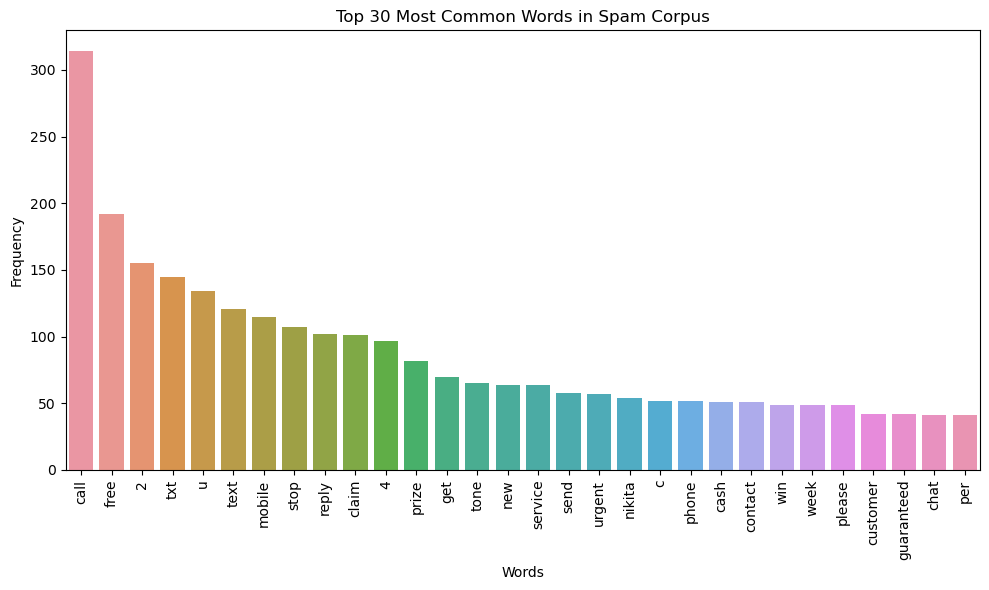

In [ ]:
# Get the most common words and their frequencies using Counter
mcw = Counter(spam_corpus).most_common(30)
words = [word[0] for word in mcw]
frequencies = [freq[1] for freq in mcw]

# Create a DataFrame from the most common words and their frequencies
dmc = pd.DataFrame({'Word': words, 'Frequency': frequencies})

# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=dmc)
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in Spam Corpus')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
ham_corpus = []
for msg in x[x['labels'] == 0]['message'].tolist():
    for word in msg:
        ham_corpus.append(word)
len(ham_corpus)

32581

C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aziz\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


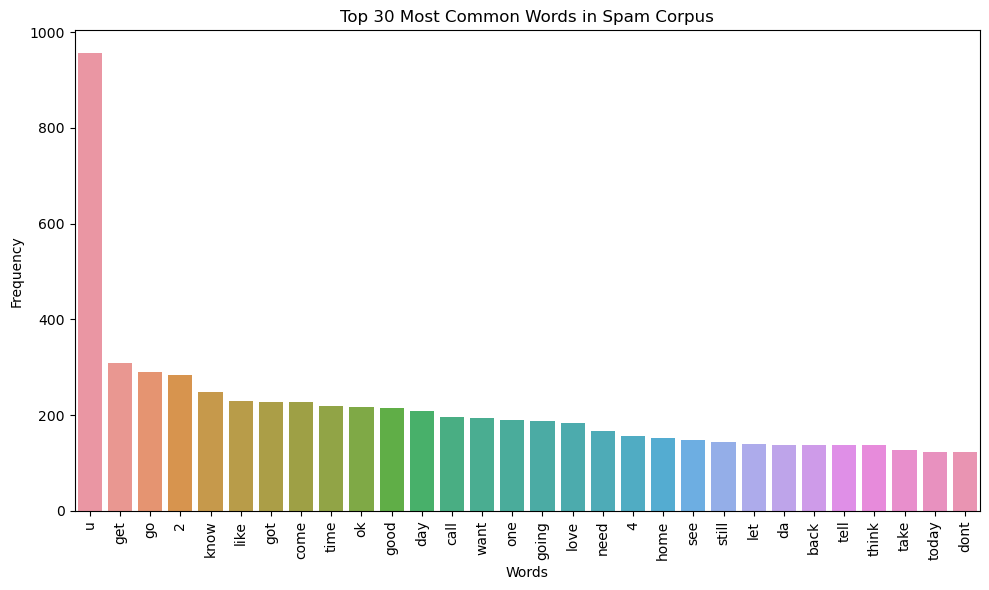

In [ ]:
# Get the most common words and their frequencies using Counter
mcw = Counter(ham_corpus).most_common(30)
words = [word[0] for word in mcw]
frequencies = [freq[1] for freq in mcw]

# Create a DataFrame from the most common words and their frequencies
dmc = pd.DataFrame({'Word': words, 'Frequency': frequencies})

# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=dmc)
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in Spam Corpus')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Model building and evaluating

Building version 1 with unbalenced data and application of lower case

In [ ]:
Model = Word2Vec(sentences=L, vector_size=100, window=20, min_count=200, workers=4)

In [ ]:
def sentence_to_vectors(sentence):
    return [Model.wv[word] for word in sentence if word in Model.wv]

embedded_sentences = [sentence_to_vectors(sentence) for sentence in L]

In [ ]:
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(embedded_sentences, dtype='float32')

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, x['labels'], test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(padded_sequences.shape[1], padded_sequences.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
104/104 [==============================] - 3s 8ms/step - loss: 0.4306 - accuracy: 0.8721 - val_loss: 0.3398 - val_accuracy: 0.8924
Epoch 2/10
104/104 [==============================] - 0s 4ms/step - loss: 0.3733 - accuracy: 0.8733 - val_loss: 0.3377 - val_accuracy: 0.8924
Epoch 3/10
104/104 [==============================] - 0s 4ms/step - loss: 0.3671 - accuracy: 0.8733 - val_loss: 0.3242 - val_accuracy: 0.8924
Epoch 4/10
104/104 [==============================] - 1s 5ms/step - loss: 0.3572 - accuracy: 0.8733 - val_loss: 0.3127 - val_accuracy: 0.8924
Epoch 5/10
104/104 [==============================] - 0s 4ms/step - loss: 0.3542 - accuracy: 0.8733 - val_loss: 0.3330 - val_accuracy: 0.8924
Epoch 6/10
104/104 [==============================] - 0s 5ms/step - loss: 0.3403 - accuracy: 0.8742 - val_loss: 0.2990 - val_accuracy: 0.8924
Epoch 7/10
104/104 [==============================] - 1s 5ms/step - loss: 0.3306 - accuracy: 0.8758 - val_loss: 0.2875 - val_accuracy: 0.8996
Epoch 

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

33/33 [==============================] - 0s 2ms/step - loss: 0.3271 - accuracy: 0.8723
Test accuracy: 0.8723404407501221


In [ ]:
y_pred_probs = model.predict(X_test)
# Convert probabilities to class labels
y_pred_classes = (y_pred_probs > 0.5).astype('int32')
y_pred_classes = y_pred_classes.flatten()
report = classification_report(y_test, y_pred_classes)
print(report)

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       889
           1       0.67      0.18      0.28       145

    accuracy                           0.87      1034
   macro avg       0.77      0.58      0.61      1034
weighted avg       0.85      0.87      0.84      1034



C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Conclusion : Decent performance but as the dataset is so unbalanced the model struggles to classify or detect spams because its a minority in the dataset. So in Version 2 we will try to improve the model's recall for spam category by :

-> trying to balance data

-> keep the influence of capitalised letters feature .



Building version 2

In [ ]:
# kinda repeating some of the old tasks in preprocesing and data analysing
path = "C:\\Users\\Aziz\\Desktop\\Spam Detection\\archive\\spam.csv"
encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1', 'utf-16']

for encoding in encodings_to_try:
    try:
        z = pd.read_csv(path, encoding=encoding)
        print("File read successfully with encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("UnicodeDecodeError with encoding:", encoding)
        pass
c = ['v1', 'v2']
z = z[c]
z.rename(columns = {'v1':'labels', 'v2':'message'}, inplace=True)
z.drop_duplicates(inplace=True)
z['labels'] = encoder.fit_transform(z['labels'])
z['message'] = z['message'].apply(corr_text)
z['message'] = z['message'].apply(tokenise_filter)
z.head()

UnicodeDecodeError with encoding: utf-8
File read successfully with encoding: latin-1


C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,labels,message
0,0,"[To, point, crazy, Available, boris, n, great, world, la, e, buffet, Line, got, wat]"
1,0,"[K, war, Joking, u]"
2,1,"[Free, entry, 2, wily, come, win, Up, final, must, May, 2005, Next, 87121, receive, entry, question, st, txt, rate, T, C, apply, 08452810075over18]"
3,0,"[U, dun, say, early, U, c, already, say]"
4,0,"[Ah, I, think, go, u, life, around, though]"


In [ ]:
zc= z['labels'].value_counts()
zc

labels
0    4516
1     653
Name: count, dtype: int64

In [ ]:
spam_corpus1 = []
for msg in z[z['labels'] == 1]['message']:
    for word in msg:
        spam_corpus1.append(word)



ham_corpus1 = []
for msg in z[z['labels'] == 0]['message']:
    for word in msg:
        ham_corpus1.append(word)




Upsampling the spam class

In [ ]:
# The idea is to build a dedicated lstm model and train it to generate fake words (spam) , the words generated dont have to be meaningful to avoid overfitting
# of the model that gona classify  later on but it would be enough the syntetic words have a part or sequence of the  spam corpus


# Assuming 'text' is a long list of words representing the minority class
text = ' '.join(spam_corpus1)  # Concatenate the list into a single string

# Create a character-level mapping
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Prepare input and output data for the LSTM model
maxlen = 8  # Define the length of sequences
step = 1   # Define the step size for sequences
sentences = []  # Input sequences
next_chars = []  # Output sequences

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i + maxlen])
    next_chars.append(text[i + maxlen])

# Vectorization
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# Define and train the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit(x, y, batch_size=128, epochs=30)

# Function to generate new words
def generate_word(length=10):
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

    for i in range(length):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.random.choice(len(chars), p=preds)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

    return generated.replace(" ", "")  # Remove potential spaces




C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\3868177869.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
C:\Users\Aziz\AppData\Local\Temp\ipykernel_7848\3868177869.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)


Epoch 1/30
483/483 [==============================] - 6s 9ms/step - loss: 3.1825
Epoch 2/30
483/483 [==============================] - 5s 10ms/step - loss: 2.6185
Epoch 3/30
483/483 [==============================] - 5s 10ms/step - loss: 2.4128
Epoch 4/30
483/483 [==============================] - 5s 10ms/step - loss: 2.2718
Epoch 5/30
483/483 [==============================] - 5s 10ms/step - loss: 2.1587
Epoch 6/30
483/483 [==============================] - 5s 10ms/step - loss: 2.0583
Epoch 7/30
483/483 [==============================] - 5s 10ms/step - loss: 1.9699
Epoch 8/30
483/483 [==============================] - 5s 10ms/step - loss: 1.8901
Epoch 9/30
483/483 [==============================] - 5s 10ms/step - loss: 1.8146
Epoch 10/30
483/483 [==============================] - 5s 10ms/step - loss: 1.7475
Epoch 11/30
483/483 [==============================] - 5s 10ms/step - loss: 1.6851
Epoch 12/30
483/483 [==============================] - 5s 10ms/step - loss: 1.6257
Epoch 13/30
48

In [ ]:
synthetic_data = []
for _ in range(500):
    l=  [generate_word() for _ in range(8)]
    synthetic_data.append({'message': l, 'labels': 1})

# Convert the list of dictionaries to a DataFrame
syntheticZ = pd.DataFrame(synthetic_data)

# Concatenate the original DataFrame and the synthetic DataFrame
z2 = pd.concat([z, syntheticZ], ignore_index=True)

# Shuffle the combined DataFrame randomly
z2 = z2.sample(frac=1).reset_index(drop=True)
z2.to_csv('z2_updated.csv', index=False)



In [ ]:
z2 = pd.read_csv('z2_updated.csv')
zc= z2['labels'].value_counts()
zc

labels
0    4516
1    1153
Name: count, dtype: int64

Downsampling the Ham class

In [ ]:


#check if all words in a list  belongs to a spam corpus
def all_words_in_spam(word_list):
    return all(word in spam_corpus1 for word in word_list)



# Extract all words from 'ham' messages
hm = z2[z2['labels'] == 0]['message']
all_words_ham = [word for sublist in hm for word in sublist]

# Count the occurrences of each word
wc = Counter(all_words_ham)

# Calculate the frequency of each word
total_words = len(all_words_ham)
wf = {word: count / total_words for word, count in wc.items()} #dictionary mapping word and its frequency

#try to find list of words where all words belong to ham corpuses and their frequency of appearence <= 20 percent
def check_word_frequency(word_list, wf):
    return all(wf.get(word, 0) <= 0.3 for word in word_list)

def all_words_in_ham(word_list, wf):
    return all(word in ham_corpus1 for word in word_list) and check_word_frequency(word_list, wf)





In [ ]:
# Filter rows where all words belong to ham corpus and their frequency of appearance <= 20%
lines_dropped = 0
for index, row in z2.iterrows():
    if row['labels'] == 0:  # Check if the row label is 'ham'
        if all_words_in_spam(row['message']) or all_words_in_ham(row['message'], wf):
            z2.drop(index, inplace=True)
            lines_dropped += 1
            if lines_dropped == 1500:  # Terminate after dropping 1500 rows
                break

print("Number of 'ham' lines dropped:",lines_dropped )

Number of 'ham' lines dropped: 1500


In [ ]:
zc= z2['labels'].value_counts()
zc

labels
0    3016
1    1153
Name: count, dtype: int64

In [ ]:
Model = Word2Vec(sentences=L, vector_size=100, window=20, min_count=200, workers=4)

In [ ]:
def sentence_to_vectors(sentence):
    return [Model.wv[word] for word in sentence if word in Model.wv]

embedded_sentences = [sentence_to_vectors(sentence) for sentence in L]

In [ ]:
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(embedded_sentences, dtype='float32')

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, z2['labels'], test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(padded_sequences.shape[1], padded_sequences.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
84/84 [==============================] - 28s 231ms/step - loss: 0.2506 - accuracy: 0.9063 - val_loss: 0.1114 - val_accuracy: 0.9730
Epoch 2/10
84/84 [==============================] - 14s 170ms/step - loss: 0.1459 - accuracy: 0.9606 - val_loss: 0.1024 - val_accuracy: 0.9715
Epoch 3/10
84/84 [==============================] - 14s 170ms/step - loss: 0.3316 - accuracy: 0.9052 - val_loss: 0.2451 - val_accuracy: 0.9385
Epoch 4/10
84/84 [==============================] - 14s 172ms/step - loss: 0.1996 - accuracy: 0.9475 - val_loss: 0.1548 - val_accuracy: 0.9595
Epoch 5/10
84/84 [==============================] - 15s 180ms/step - loss: 0.1808 - accuracy: 0.9516 - val_loss: 0.1482 - val_accuracy: 0.9625
Epoch 6/10
84/84 [==============================] - 16s 185ms/step - loss: 0.1760 - accuracy: 0.9513 - val_loss: 0.1445 - val_accuracy: 0.9595
Epoch 7/10
84/84 [==============================] - 15s 184ms/step - loss: 0.1639 - accuracy: 0.9516 - val_loss: 0.1227 - val_accuracy: 0.9595

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

27/27 [==============================] - 2s 72ms/step - loss: 0.1394 - accuracy: 0.9544
Test accuracy: 0.9544364213943481


In [ ]:
y_pred_probs = model.predict(X_test)
# Convert probabilities to class labels
y_pred_classes = (y_pred_probs > 0.5).astype('int32')
y_pred_classes = y_pred_classes.flatten()
report = classification_report(y_test, y_pred_classes)
print(report)

27/27 [==============================] - 3s 65ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       617
           1       0.99      0.83      0.91       217

    accuracy                           0.95       834
   macro avg       0.97      0.92      0.94       834
weighted avg       0.96      0.95      0.95       834



C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Aziz\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Conclusion : The overall improvement of the model's performances